In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from joblib import Parallel, delayed
from itertools import product

import sys
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
from utilities2014 import *
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tables import *

import compute_pie

In [5]:
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=17)
dm._load_image()

In [6]:
textonmap = dm.load_pipeline_result('texMap', 'npy')
textonmap_viz = dm.load_pipeline_result('texMap', 'png')
n_texton = len(np.unique(textonmap)) - 1

image = dm.image_rgb
mask = dm.mask

mys, mxs = np.where(mask)
mys = mys.astype(np.int16)
mxs = mxs.astype(np.int16)

height, width = image.shape[:2]

In [7]:
n_theta = 12
theta_binwidth = 2*np.pi/n_theta

In [ ]:
b = time.time()

# if os.path.exists('/home/yuncong/csd395/H'):

#     with open_file('/home/yuncong/csd395/H', mode="r") as f:
#         H = f.root.data.read()

# else:
    
box_indices = np.dstack(np.meshgrid(np.arange(-radius, radius+1), np.arange(-radius, radius+1))).astype(np.int16)

filters = Filters(complevel=9, complib='blosc')

for ri, radius in enumerate([50,100,200]):

    norms = np.linalg.norm(box_indices, axis=-1)
    
    if ri == 0:
        circle_indices = box_indices[norms <= radius]
    else:
        circle_indices = box_indices[(norms <= radius[ri]) & (norms > radius[ri-1])]

    angles = np.arctan2(circle_indices[:,0], circle_indices[:,1])
    angles[angles < 0] += 2*np.pi
    angular_bins = np.int0(angles/theta_binwidth)
    pie_indices = [circle_indices[angular_bins==k] for k in range(n_theta)]

    H = Parallel(n_jobs=16)(delayed(compute_pie.compute_pie_histogram)(textonmap, pie_indices[s], 
                                                       mys, mxs, radius, height, width, n_texton) 
                            for s in range(n_theta))

    with open_file('/home/yuncong/csd395/H%d.hdf'%ri, mode="w") as f:
        t = f.create_carray('/', 'data', Int64Atom(), filters=filters, obj=np.asarray(H))

print time.time() - b

In [12]:
def chi2s(h1s, h2s):
    return np.nansum((h1s-h2s)**2/(h1s+h2s).astype(np.float), axis=1)

def compute_halfdisc_histogram_diff(start_bin, mys, mxs):
    
    Gs = np.zeros((height, width), np.float)

    first_half_bins = np.arange(start_bin, start_bin+n_theta/2)%n_theta
    second_half_bins = np.arange(start_bin+n_theta/2, start_bin+n_theta)%n_theta

#     q = time.time()
    H_halfdisk1 = np.sum(H[first_half_bins[:,None], mys, mxs], axis=0)
    H_halfdisk2 = np.sum(H[second_half_bins[:,None], mys, mxs], axis=0)
#     print '1', time.time() - q
    
#     q = time.time()
    H_halfdisk1 = H_halfdisk1.astype(np.float)
    H_halfdisk2 = H_halfdisk2.astype(np.float)
#     print '2', time.time() - q
    
#     q = time.time()
    H_halfdisk1 /= H_halfdisk1.sum(axis=-1)[:,None]
    H_halfdisk2 /= H_halfdisk2.sum(axis=-1)[:,None]
#     print '3', time.time() - q
    
#     t = time.time()
    Gs[mys, mxs] = chi2s(H_halfdisk1, H_halfdisk2)
#     print '4', time.time() - t

    return Gs

In [13]:
# %time G = Parallel(n_jobs=16)(delayed(compute_halfdisc_histogram_diff)(s, mys, mxs) for s in range(n_theta/2))

G = np.empty((n_theta/2, height, width))
for s in range(n_theta/2):
    t = time.time()
    G[s] = compute_halfdisc_histogram_diff(s, mys, mxs)
    print time.time() - t

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from IPython.kernel.zmq import kernelapp as app


22.3966009617
20.4167599678
20.4395568371
20.462553978
20.4462060928
20.4549400806


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide


In [29]:
OE = G.max(axis=0)
viz = plt.cm.jet(OE/np.nanmax(OE));
display(viz)

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [30]:
display(image)

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [21]:
vmax = np.nanmax(G)
viz = plt.cm.jet(G[0]/vmax);
display(viz)

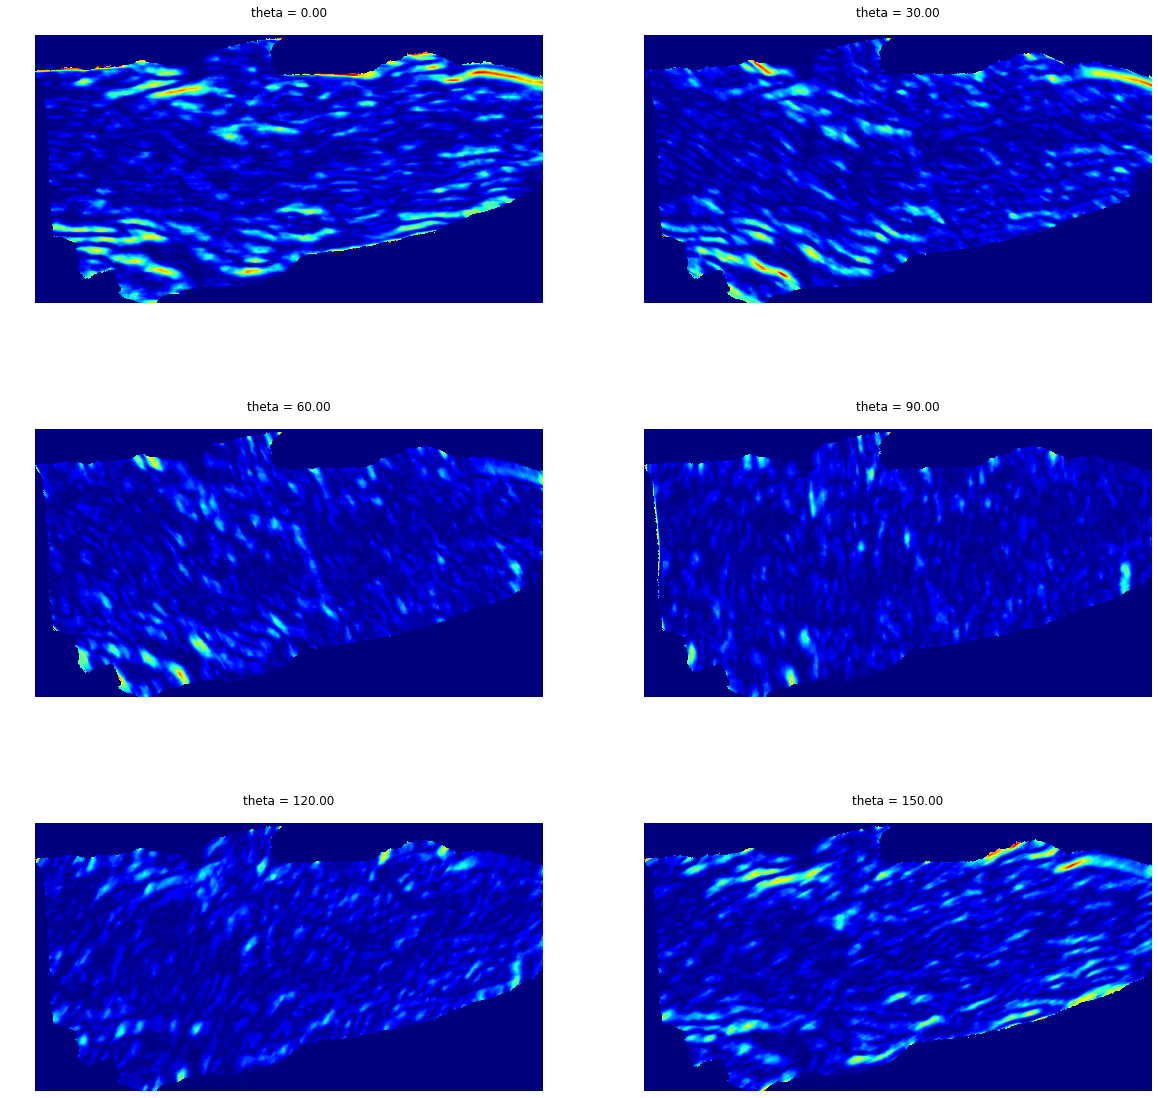

In [36]:
thetas = np.linspace(0, np.pi, n_theta/2+1)

n_cols = 2
n_rows = n_theta/2/n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20));
for s in range(n_theta/2):
    ax = axes[s/n_cols, s%n_cols]
    ax.matshow(G[s], vmin=0, vmax=vmax);
    ax.set_title('theta = %.2f'%np.rad2deg(thetas[s]))
    ax.set_axis_off();